## Imputations methods

In this notebook we are going to explore different imputation methods

For a more theoretical perspective consider http://www.stat.columbia.edu/~gelman/arm/missing.pdf

We are dealing with data probably belonging to the category missing by design (some values are too expensive to obtain)

Also look at https://www.paultwin.com/wp-content/uploads/Lodder_1140873_Paper_Imputation.pdf

TODO: also take into account more complicated methods that directly tackle the problem of classification such as BoostClean https://arxiv.org/pdf/1711.01299.pdf
TODO: also try EM imputation

For a more detail description check the book "Flexible imputationn of missing data" https://stefvanbuuren.name/fimd/


For discriminative models it is more elaborate, since that is not possible. There are a number of approaches. Gharamani and Jordan http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf describe a principled approach, where missing values are treated like hidden variables, and a variant of the EM algorithm is used to estimate them. In a similar fashion, Smola et al. http://www.gatsby.ucl.ac.uk/aistats/fullpapers/234.pdf describe a variant of the SVM algorithm which explicitly tackles the problem.

In out case the missingness of values is not random but can be an indicator by itself

First we need to define a little clearer the setting exactly. For startes we are going to deal with only the 5 most common diseases. Also for starters we are merely going to deal with classifying based on the first diagnosis given only. We are going to consider the multiclass classification problem first, but we are should also check the binary classification one to compare with established methods.

In [94]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

In [95]:
behaviour_data = pd.read_csv('DataScience2019_MRI/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1


most_common_disorders = behaviour_data['DX_01_Cat'].value_counts().keys().values[:keep_most_common_diseases]
behaviour_data = behaviour_data[behaviour_data['DX_01_Cat'].isin(most_common_disorders)]
behaviour_data = behaviour_data.reset_index(drop=True)

In [96]:
most_common_disorders

array(['Neurodevelopmental Disorders', 'No Diagnosis Given',
       'Anxiety Disorders', 'Depressive Disorders', 'Disruptive',
       'Trauma and Stressor Related Disorders'], dtype=object)

In [97]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safely remove previous columns describing diagnosis

In [98]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [99]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

It is also reasonable to assume that we need to drop columns with too many Nans?

In [100]:
# threshold = 0.8

# columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

# print('Droping this many columns:', np.sum(columns_mask))

# dropped_columns = behaviour_data.columns[columns_mask]

# behaviour_data = behaviour_data.drop(columns=dropped_columns)
# behaviour_data = behaviour_data.reset_index(drop=True)

In [101]:
print('Shape', behaviour_data.shape)
behaviour_data.head(5)

Shape (1760, 312)


,Anonymized.ID,EID,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,...,YSR_SC,YSR_Ext,YSR_Int,YSR_Total,Neurodevelopmental Disorders,No Diagnosis Given,Anxiety Disorders,Depressive Disorders,Disruptive,Trauma and Stressor Related Disorders
0,A00078864,NDARYM832PX3,1,7.048254,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,1,0,0,0
1,A00078865,NDARNJ687DMC,1,6.348163,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,1,0,0
2,A00078866,NDARRM363BXZ,0,10.052589,1,NaN,NaN,NaN,17.0,118.0,...,NaN,NaN,NaN,NaN,1,0,0,0,0,0
3,A00078867,NDARUW586LLL,1,12.319415,1,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,29.0,85.0,0,0,0,1,0,0
4,A00078868,NDARDC298NW4,0,13.901437,1,NaN,NaN,NaN,33.0,154.0,...,11.0,10.0,26.0,70.0,1,0,0,0,0,0


We are going to explore some different imputation methods. More specifically:
1. Do nothing
2. Fill all missing values with a dummy value
3. Imputation Using (Mean/Median/Most Frequent) Values
4. Imputation Using k-NN, Randomforest
5. MICE (TODO)
6. Multiple imputer
7. Add features based on whether the value exists or not

For a comparison with a more naive baseline check out @gvasilako 's notebook for both multilabel and per class metrics

In [102]:
import sys
import xgboost as xgb
from missingpy import KNNImputer, MissForest
import impyute as impy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning

In [103]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'EID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

processed = behaviour_data.drop(columns=columns_to_drop)
most_common_disorders = list(most_common_disorders)

In [104]:
def run_binary_classification(dataset, diseases_to_run_for, clf, imputer, imputer_requires_disorder, 
                              drop_missing_threshold, *args):
    for check_disorder in most_common_disorders[:diseases_to_run_for]:
        
        if check_disorder == no_diagnosis_given:
            continue
            
        # only include patients that have that particular disease vs patients that are healthy
        temp = dataset[(dataset[check_disorder] == 1) | (dataset[healthy_diagnosis] == 1)]
        
        pos = most_common_disorders.index(check_disorder)

        columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]
        temp = temp.drop(columns=columns_to_drop)
        
        if drop_missing_threshold is not None:
            # drop features missing in drop_missing_threshold percent of the time or more
            # The missingpy algorithms to work require that not columsn have more than 80% missing values

            columns_mask = pd.isnull(temp).sum() / temp.shape[0] > threshold

            print('Droping this many columns:', np.sum(columns_mask))

            dropped_columns = temp.columns[columns_mask]

            temp = temp.drop(columns=dropped_columns)
#             processed_80 = processed_80.reset_index(drop=True)

        train, test = train_test_split(temp, test_size=0.3, random_state=17)
        
        if imputer_requires_disorder:
            train, test = imputer(train, test, check_disorder, *args)
        else:
            train, test = imputer(train, test, *args)

        clf.fit(train.drop(columns=[check_disorder]), train[check_disorder])
        preds = clf.predict(test.drop(columns=[check_disorder]))
        y_test = test[check_disorder]

        print('================================= {0} ================================='.format(check_disorder))

        precision, recall, _, _ = precision_recall_fscore_support(y_test, preds)
        accuracy = accuracy_score(y_test, preds)

        print('accuracy {:.3f} precision {:.3f} {:.3f} recall {:.3f} {:.3f}' \
              .format(accuracy, precision[0], precision[1], recall[0], recall[1]))

        print(confusion_matrix(y_test, preds))

Before actually droping columns that cannot be incorporated for the next analysis as they are categorical values, we should check their correlation with the predicted classes!

In [105]:
disorder_corr = np.zeros((len(columns_to_drop) - 2, len(most_common_disorders)))

# the disorder to find the correlation for
for index, disorder in enumerate(most_common_disorders):
    dropped_columns_dataset = behaviour_data[columns_to_drop + [most_common_disorders[index]]]

    # remove the anonymized id and the EID
    for col in dropped_columns_dataset[2:-1]:
        dropped_columns_dataset[col] = dropped_columns_dataset[col].astype('category').cat.codes

    disorder_corr[:, index] = dropped_columns_dataset[dropped_columns_dataset.columns[2:]].corr()[most_common_disorders[index]][:-1].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


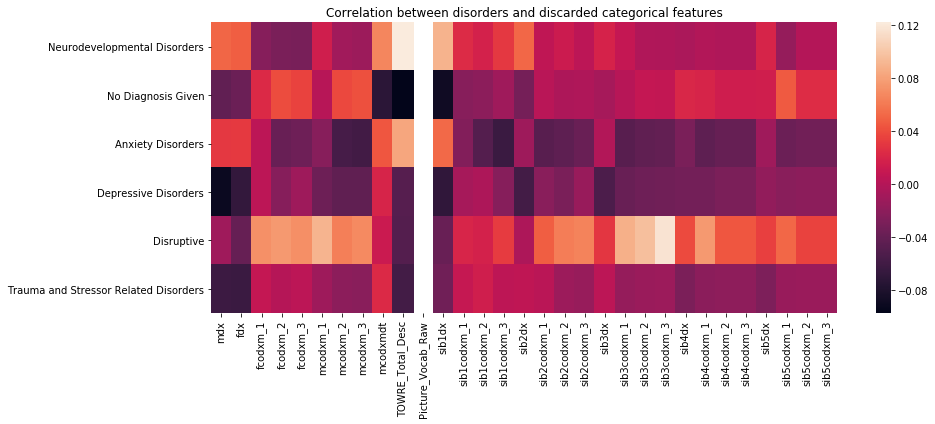

In [106]:
correlation_df = pd.DataFrame(disorder_corr.T, columns=columns_to_drop[2:], index=most_common_disorders)
sns.heatmap(correlation_df)

plt.title('Correlation between disorders and discarded categorical features')
plt.ylim([len(most_common_disorders), 0])
plt.tight_layout()

plt.show()

### 1st approach: Do nothing

Some algorithms such as XGBoost

In [84]:
def do_nothing(x, y):
    return x, y

run_binary_classification(processed, 1, xgb.XGBClassifier(), do_nothing, False, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.875 precision 0.614 0.903 recall 0.403 0.956
[[ 27  40]
 [ 17 372]]


In [55]:
temp

,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,ARI_P_Total_Score,ARI_S_Total_Score,...,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total,Anxiety Disorders
0,1,7.048254,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,0,13.484941,1,NaN,19.0,102.0,17.0,113.0,NaN,NaN,...,NaN,6.0,9.0,9.0,0.0,9.0,6.0,27.0,55.0,1
8,1,17.203855,1,NaN,23.0,104.0,12.0,117.0,NaN,5.0,...,NaN,8.0,9.0,3.0,10.0,10.0,18.0,22.0,62.0,1
9,1,12.379192,1,NaN,NaN,NaN,18.0,146.0,NaN,NaN,...,NaN,11.0,14.0,4.0,4.0,8.0,15.0,26.0,79.0,1
10,0,9.153661,1,NaN,NaN,NaN,20.0,116.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,0,10.046885,3,NaN,20.0,110.0,18.0,115.0,0.0,NaN,...,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1749,1,18.881359,3,5.0,16.0,122.0,17.0,118.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1751,0,17.101756,3,NaN,15.0,111.0,15.0,143.0,6.0,8.0,...,NaN,16.0,1.0,2.0,6.0,4.0,22.0,7.0,43.0,1
1752,1,6.517796,1,NaN,14.0,91.0,19.0,133.0,1.0,2.0,...,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### 2nd approach: Fill all missing values with a dummy value 

(For this refer to @gvasilak 's notebook)

### 3rd approach: Imputation Using (Mean/Median/Most_frequent) Values

In [89]:
strategy = 'median'
assert strategy in ['mean', 'median', 'most_frequent']

def imputer(x, y, strategy):
    if strategy == 'mean':
        filling = x.mean()
    elif strategy == 'median':
        filling = x.median()
    elif strategy == 'most_frequent':
        filling = x.mode().iloc[0]
    
    return x.fillna(filling), y.fillna(filling)

clf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
run_binary_classification(processed, 1, clf, imputer, False, None, strategy)

================================= Neurodevelopmental Disorders =================================
accuracy 0.897 precision 0.778 0.907 recall 0.418 0.979
[[ 28  39]
 [  8 381]]


### 4th approach: Imputation Using k-NN

The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. 

In [93]:
threshold = 0.8

columns_mask = pd.isnull(processed).sum() / processed.shape[0] > threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = processed.columns[columns_mask]

processed = processed.drop(columns=dropped_columns)
processed_80 = processed_80.reset_index(drop=True)

Droping this many columns: 95


In [90]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = KNNImputer(n_neighbors=5, weights="distance")

run_binary_classification(processed_80, 1, clf, imputer_fun, False, 0.8, my_inputer)

Droping this many columns: 1


/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
/home/sotiris/.local/lib/python3.7/site-packages/missingpy/knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/home/sotiris/.local/lib/python3.7/site-pa

================================= Neurodevelopmental Disorders =================================
accuracy 0.879 precision 0.650 0.901 recall 0.388 0.964
[[ 26  41]
 [ 14 375]]


In [ ]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y

my_inputer = MissForest(max_depth=4)

run_binary_classification(processed_80, 1, clf, imputer_fun, False, 0.8, my_inputer)

### 5th approach: MICE

First we can try using EM to complete the missing values!

In [ ]:
def imputer_em(x, y, disorder):
    x_values = x.drop(columns=disorder).values
    y_values = y.drop(columns=disorder).values
    total_values = np.concatenate((x_values, y_values), axis=0)

    total_values = impy.em(total_values)

    x.loc[:, x.columns != disorder] = total_values[:x.shape[0]]
    y.loc[:, y.columns != disorder] = total_values[len(total_values) - y.shape[0]:]
    
    return x, y

run_binary_classification(processed_80, 1, clf, imputer_em, True, None)

One of the most popular methods is using MICE. What is the difference between MICE and other multiple imputers?

In [ ]:
from fancyimpute import MICE as MICE



## 6th approach: Multiple imputer

In [ ]:
from autoimpute.imputations import SingleImputer, MultipleImputer

def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)
    
    return x_new, y_new


si = SingleImputer() # imputation methods, passing through the data once
mi = MultipleImputer() # imputation methods, passing through the data multiple times

run_binary_classification(processed, 1, clf, imputer_fun, False, None, mi)

### 7th approach: Add features indicating if the value os misisng or not

For this part we should take into account which exact features can have Nan values

The features that do not take any null values are 'Sex', 'Age', 'Study.Site' and the disorder we are currently checking for

In [139]:
def process_dataset(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    
    # change column naming to enable the inner join
    x1.columns = [col + '_existence' for col in x1.columns]
    return x1.join(x)

def data_and_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    rest_of_columns = list(x.columns.values)
    for c in cols:
        rest_of_columns.remove(c)
    
    x_new = process_dataset(x, cols)
    y_new = process_dataset(y, cols)
    
    x_new[rest_of_columns], y_new[rest_of_columns] = imputer(x_new[rest_of_columns], 
                                                             y_new[rest_of_columns], 
                                                             'most_frequent')
    return x_new, y_new

run_binary_classification(processed, 1, clf, data_and_existence_of_features, True, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.820 precision 0.739 0.833 recall 0.405 0.954
[[ 51  75]
 [ 18 374]]


## Existence of features

To explore the severity of existence of a feature for the correct classification, we only try to predict based on the existence of the features only and not the actual value

In [118]:
def process_dataset_only_existence(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')
    x2 = x[cols]
    
    return x1.join(x2)

def only_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    return process_dataset_only_existence(x, cols), process_dataset_only_existence(y, cols)

run_binary_classification(processed, 1, clf, only_existence_of_features, True, None)

================================= Neurodevelopmental Disorders =================================
accuracy 0.720 precision 0.398 0.791 recall 0.294 0.857
[[ 37  89]
 [ 56 336]]


## Use an autoencoder as imputation method

In [110]:
dataset = processed

check_disorder = most_common_disorders[0]

# only include patients that have that particular disease vs patients that are healthy
temp = dataset[(dataset[check_disorder] == 1) | (dataset[healthy_diagnosis] == 1)]

pos = most_common_disorders.index(check_disorder)

columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]
temp = temp.drop(columns=columns_to_drop)

train, test = train_test_split(temp, test_size=0.3, random_state=17)
train_clear = train.drop(columns=[check_disorder])
test_clear = test.drop(columns=[check_disorder])

In [111]:
train_clear

,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,ARI_P_Total_Score,ARI_S_Total_Score,...,WISC_PSI,WISC_FSIQ,YSR_AB,YSR_AD,YSR_WD,YSR_RBB,YSR_SC,YSR_Ext,YSR_Int,YSR_Total
1512,0,12.866301,3,NaN,16.0,90.0,13.0,107.0,0.0,0.0,...,75.0,100.0,4.0,13.0,7.0,0.0,6.0,4.0,26.0,64.0
150,0,7.784964,1,NaN,21.0,89.0,19.0,111.0,0.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701,0,10.181040,1,NaN,22.0,104.0,22.0,112.0,3.0,2.0,...,83.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,0,6.333903,3,NaN,12.0,88.0,8.0,106.0,0.0,1.0,...,83.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1464,0,7.317134,1,NaN,21.0,103.0,19.0,108.0,2.0,1.0,...,129.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,1,10.695185,2,NaN,18.0,102.0,15.0,116.0,1.0,3.0,...,86.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1644,0,5.173511,1,NaN,20.0,105.0,NaN,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,1,5.797170,2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1483,1,15.793634,3,NaN,19.0,104.0,25.0,141.0,0.0,3.0,...,69.0,82.0,10.0,5.0,4.0,4.0,8.0,14.0,17.0,56.0


In [160]:
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import os


def get_batches(iterable, batch_size=64, do_shuffle=True):
    if do_shuffle:
        iterable = shuffle(iterable)

    length = len(iterable)
    for ndx in range(0, length, batch_size):
        iterable_batch = iterable[ndx: min(ndx + batch_size, length)]
        yield iterable_batch


def get_reconstruction_loss(true, preds, mask):
    loss = np.mean(((true - preds) ** 2) * mask, axis=1)
    return np.mean(loss, axis=0)


DEFAULT_LOG_PATH = './autoencoder'


class Autoencoder:
    training = None
    input_ = None
    input_mask = None
    intermediate_representation = None
    input_reconstructed = None
    loss = None

    def __init__(self,
                 number_of_features,
                 activation=tf.nn.relu,
                 layers=None,
                 dropout=None,
                 regularization=0,
                 masking=0.5):

        self.activation = activation

        if layers is None:
            self.layers = [15, 15, 15]
        else:
            self.layers = layers

        self.number_of_features = number_of_features

        self.masking = masking
        self.dropout = dropout

        use_regularization = (regularization > 0)
        self.use_regularization = use_regularization

        if regularization == 0:
            # set to small value to avoid tensorflow error
            # use_regularization = False in this case and will not contribute towards the final loss
            self.regularization = 0.1
        else:
            self.regularization = regularization

    def build_graph(self):

        self.training = tf.placeholder(tf.bool, shape=[], name='training')

        # these do not contain the wanted prediction
        self.input_ = tf.placeholder(tf.float32, shape=[None, self.number_of_features], name='input')

        self.input_mask = tf.placeholder(tf.float32, shape=[None, self.number_of_features], name='input_mask')

        self.intermediate_representation = self.encode(self.input_)

        self.input_reconstructed = self.decode(self.intermediate_representation)

        if self.input_mask is not None:
            self.loss = tf.reduce_mean(((self.input_ - self.input_reconstructed) ** 2) * self.input_mask)
        else:
            self.loss = tf.reduce_mean((self.input_ - self.input_reconstructed) ** 2)

        if self.use_regularization:
            self.loss += tf.losses.get_regularization_loss()

    def encode(self,
               input_):

        if self.masking > 0:
            # mask randomly some of the inputs
            input_ = tf.layers.dropout(input_, rate=self.masking, training=self.training)

        x = input_
        # important to use relu as a first layer to make all unobserved values set to 0?
        for i, layer in enumerate(self.layers):
            x = tf.layers.dense(x, layer, use_bias=True, name='input_layer_1_' + str(i),
                                activation=self.activation,
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(self.regularization))
            if self.dropout is not None:
                x = tf.layers.dropout(x, rate=self.dropout, training=self.training)

        return x

    def decode(self,
               intermediate):

        x = intermediate
        for i, layer in enumerate(self.layers[::-1][:-1]):
            x = tf.layers.dense(x, layer, use_bias=True, name='input_layer_2_' + str(i),
                                activation=self.activation,
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(self.regularization))
            if self.dropout is not None:
                x = tf.layers.dropout(x, rate=self.dropout, training=self.training)

        x = tf.layers.dense(x, self.number_of_features, use_bias=True, name='input_layer_2_final',
                            activation=self.activation,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(self.regularization))

        if self.dropout is not None:
            x = tf.layers.dropout(x, rate=self.dropout, training=self.training)

        return x

    def reconstruct_with_session(self,
                                 sess,
                                 data):

        # much faster to reconstruct the whole table and make predictions from it
        data_reconstructed = np.zeros((data.shape[0], self.number_of_features))

        for rows in get_batches(list(range(data.shape[0])), batch_size=1024, do_shuffle=False):
            rows_features = [data[i, :] for i in rows]

            ratings_reconstructed = sess.run(self.input_reconstructed,
                                             feed_dict={
                                                 self.input_: rows_features,
                                                 self.training: False
                                             })

            data_reconstructed[rows] = ratings_reconstructed

        return data_reconstructed

    def reconstruct(self,
                    data,
                    log_path=None):

        if log_path is None:
            log_path = DEFAULT_LOG_PATH

        with tf.Graph().as_default():
            with tf.Session() as sess:
                self.build_graph()

                saver = tf.train.Saver()
                saver.restore(sess, tf.train.latest_checkpoint(log_path))

                reconstructed = self.reconstruct_with_session(sess, data)

                return reconstructed

    def fit(self,
            data,
            data_mask,
            test_data=None,
            test_data_mask=None,
            n_epochs=350,
            decay_steps=None,
            learning_rate=None,
            decay=None,
            log_path=None,
            verbose=True,
            print_every_epochs=10):

        if decay_steps is None:
            # empirical
            decay_steps = data.shape[0] // 64 * 5

        if learning_rate is None:
            learning_rate = 0.001

        if decay is None:
            decay = 0.96

        if log_path is None:
            log_path = DEFAULT_LOG_PATH

        validation = False
        if test_data is not None and test_data_mask is not None:
            validation = True

        with tf.Graph().as_default():
            with tf.Session() as sess:

                self.build_graph()

                global_step = tf.Variable(1, name='global_step', trainable=False)

                learning_rate = tf.Variable(learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
                learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay)

                # Gradients and update operation for training the model.
                opt = tf.train.AdadeltaOptimizer(learning_rate)
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

                with tf.control_dependencies(update_ops):
                    # Update all the trainable parameters
                    train_step = opt.minimize(self.loss, global_step=global_step)

                saver = tf.train.Saver(max_to_keep=3)

                # writer = tf.summary.FileWriter(log_path, sess.graph)
                # writer.flush()

                # tf.summary.scalar('loss', self.loss)
                # tf.summary.scalar('learning_rate', learning_rate)
                # summaries_merged = tf.summary.merge_all()

                sess.run(tf.global_variables_initializer())

                for epoch in range(n_epochs):
                    total_loss = 0
                    for rows in get_batches(list(range(data.shape[0]))):
                        rows_features = [data[i, :] for i in rows]
                        rows_masks = [data_mask[i, :] for i in rows]

                        # summaries_merged
                        _, loss, step = sess.run([train_step, self.loss, global_step],
                                                 feed_dict={
                                                     self.input_: rows_features,
                                                     self.input_mask: rows_masks,
                                                     self.training: True
                                                 })

                        total_loss += loss * len(rows)

                    # writer.flush()
                    total_loss = total_loss / data.shape[0]

                    if epoch % print_every_epochs == 0:
                        if verbose and validation:
                            reconstructed_train = self.reconstruct_with_session(sess, data)
                            train_loss = get_reconstruction_loss(data, reconstructed_train, data_mask)

                            reconstructed_test = self.reconstruct_with_session(sess, test_data)
                            test_loss = get_reconstruction_loss(test_data, reconstructed_test, test_data_mask)

                            print('At epoch {0:3d} train loss is {1:6.4f} and reconstruction losses are in train '
                                  '{2:6.4f} and in test {3:6.4f}'.format(epoch, total_loss, train_loss, test_loss))

                        saver.save(sess, os.path.join(log_path, "model"), global_step=epoch)


In [184]:
data = train_clear.values
test_data = test_clear.values

data_mask = ~np.isnan(data)
test_data_mask = ~np.isnan(test_data)

In [185]:
data[~data_mask] = -1
test_data[~test_data_mask] = -1

In [186]:
autoencoder = Autoencoder(data.shape[1], layers=[50, 25], masking=0.2, regularization=0)

In [187]:
autoencoder.fit(data, data_mask, test_data=test_data, test_data_mask=test_data_mask, learning_rate=1,
                print_every_epochs=1, n_epochs=100)

At epoch   0 train loss is 30060.1658 and reconstruction losses are in train 29552.0055 and in test 26843.7144
At epoch   1 train loss is 29047.9410 and reconstruction losses are in train 26940.7035 and in test 24462.1138
At epoch   2 train loss is 17574.7226 and reconstruction losses are in train 8713.6334 and in test 7972.1055
At epoch   3 train loss is 10975.8029 and reconstruction losses are in train 6652.1310 and in test 6191.9976
At epoch   4 train loss is 8714.0828 and reconstruction losses are in train 5784.6438 and in test 5411.3921
At epoch   5 train loss is 6924.4988 and reconstruction losses are in train 3908.4255 and in test 3692.7302
At epoch   6 train loss is 7171.8584 and reconstruction losses are in train 2958.3565 and in test 2814.4229
At epoch   7 train loss is 7290.1025 and reconstruction losses are in train 2747.0842 and in test 2629.0613
At epoch   8 train loss is 5466.8236 and reconstruction losses are in train 2222.2980 and in test 2141.3048
At epoch   9 train l

At epoch  76 train loss is 5250.6316 and reconstruction losses are in train 1875.3577 and in test 1826.0204
At epoch  77 train loss is 5713.5769 and reconstruction losses are in train 1894.4347 and in test 1843.4181
At epoch  78 train loss is 4707.8770 and reconstruction losses are in train 1888.2917 and in test 1839.9497
At epoch  79 train loss is 6113.9203 and reconstruction losses are in train 1802.2945 and in test 1762.1906
At epoch  80 train loss is 4800.9426 and reconstruction losses are in train 1862.2154 and in test 1816.4759
At epoch  81 train loss is 4945.9267 and reconstruction losses are in train 1910.2515 and in test 1861.4554
At epoch  82 train loss is 4414.2223 and reconstruction losses are in train 1896.8225 and in test 1848.6236
At epoch  83 train loss is 6249.7122 and reconstruction losses are in train 1887.2048 and in test 1839.5927
At epoch  84 train loss is 5618.8539 and reconstruction losses are in train 1877.0052 and in test 1828.2058
At epoch  85 train loss is 4

In [188]:
reconstructed_data = autoencoder.reconstruct(data)

INFO:tensorflow:Restoring parameters from ./autoencoder/model-99


In [189]:
data

array([[ 0.      , 12.866301,  3.      , ...,  4.      , 26.      ,
        64.      ],
       [ 0.      ,  7.784964,  1.      , ..., -1.      , -1.      ,
        -1.      ],
       [ 0.      , 10.18104 ,  1.      , ..., -1.      , -1.      ,
        -1.      ],
       ...,
       [ 1.      ,  5.79717 ,  2.      , ..., -1.      , -1.      ,
        -1.      ],
       [ 1.      , 15.793634,  3.      , ..., 14.      , 17.      ,
        56.      ],
       [ 1.      ,  7.700547,  1.      , ..., -1.      , -1.      ,
        -1.      ]])

In [190]:
new_data = data.copy()
new_data[~data_mask] = reconstructed_data[~data_mask]

In [191]:
new_data

array([[ 0.        , 12.866301  ,  3.        , ...,  4.        ,
        26.        , 64.        ],
       [ 0.        ,  7.784964  ,  1.        , ...,  0.        ,
        13.59239101, 43.98703766],
       [ 0.        , 10.18104   ,  1.        , ...,  0.        ,
        17.7919426 , 53.56770325],
       ...,
       [ 1.        ,  5.79717   ,  2.        , ...,  0.        ,
         0.        ,  6.11753988],
       [ 1.        , 15.793634  ,  3.        , ..., 14.        ,
        17.        , 56.        ],
       [ 1.        ,  7.700547  ,  1.        , ...,  0.        ,
        13.49396229, 45.43925858]])

In [192]:
data[0].astype(np.int)

array([  0,  12,   3,  -1,  16,  90,  13, 107,   0,   0,  -1,   3,   0,
        10,  20,  30,   1,   0,   1,  15,   3,   0,  -1,  -1,  -1,   3,
         2,   7,   0,   1,  12,   1,   6,  19,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  25,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   3,   2,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  31,  18,  17,  19,  20,  -1,  70,  -1,
        -1,  -1,   1,   1,   2,   1,  23, -48,  -1,  18,  10,   2,   5,
         5,  29,  25,  -1,   0,   0,  -1,  23,   2,   5,   7,  15,   0,
         3,  10,  14,  -1,  -1,  13,  17,  30,  20,  12,  35,  -1,   8,
        25,  -1,  -1,  -1,  -1,  -1,   1,   2,  17,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  21,  27,  25,  73,  -1,  -1,  -1,  -1,  -1,
        -1,   0,   0,   0,   0,   0,   3,   3,   0,   1,   0,   7,   5,
         8,   4,   0,   1,  18,   3,   6,   4,   4,   2,  10,   4,   3,
         8,   7,   2,  37,   7,   4,   7,  43,   3,   1,  21,  2

In [193]:
new_data[0].astype(np.int)

array([  0,  12,   3,   0,  16,  90,  13, 107,   0,   0,  65,   3,   0,
        10,  20,  30,   1,   0,   1,  15,   3,   0,   0,   0,   0,   3,
         2,   7,   0,   1,  12,   1,   6,  19,   0,   0,   0,   0,  16,
         0,   0,  36,  21,  25,   0,  20,  25,   0,   0,  19,  40,   0,
         0,   0,   8,   3,   4,   0,   9,  83,   3,   2,   7,   0,   6,
         2,   6,   6,   5,   0,  31,  18,  17,  19,  20,  74,  70,   0,
         4,   3,   1,   1,   2,   1,  23, -48,  92,  18,  10,   2,   5,
         5,  29,  25,   0,   0,   0,   0,  23,   2,   5,   7,  15,   0,
         3,  10,  14,  10,   0,  13,  17,  30,  20,  12,  35,   0,   8,
        25,   0,   0,   0,   0,   0,   1,   2,  17, 129,  84,   0,   0,
         0,  90,   0, 130,  21,  27,  25,  73,  45,  72,   0,  73,   0,
        43,   0,   0,   0,   0,   0,   3,   3,   0,   1,   0,   7,   5,
         8,   4,   0,   1,  18,   3,   6,   4,   4,   2,  10,   4,   3,
         8,   7,   2,  37,   7,   4,   7,  43,   3,   1,  21,  2